## Importing Libraries

In [1]:
import math, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

## PMV Calculator: Fanger's Model

In [2]:
# ---------- PMV (ISO 7730 / ASHRAE 55) ----------
def _svp_pa(t):  # saturation vapor pressure (Pa)
    return 610.5 * math.exp(17.2694 * t / (237.29 + t))

def pmv_iso(ta, tr, v, rh, met=1.2, clo=0.68):
    pa = (rh/100.0)*_svp_pa(ta)/1000.0; icl=0.155*clo; m=met*58.15; mw=m
    fcl = 1.0 if icl<=0 else (1.0+1.29*icl if icl<=0.078 else 1.05+0.645*icl)
    tcl = ta + (35.5-ta)/(3.5*icl+0.1) if icl>0 else ta
    hcf = 12.1*math.sqrt(max(v,1e-8))
    for _ in range(150):
        hr = 4*5.67e-8*((tcl+273.15+tr+273.15)/2)**3
        hc = max(hcf, 2.38*abs(tcl-ta)**0.25)
        tnew=((35.7-0.028*mw)+icl*fcl*(hr*tr+hc*ta))/(1+icl*fcl*(hr+hc))
        if abs(tnew-tcl)<1e-6: break
        tcl=tnew
    r=3.96e-8*fcl*((tcl+273.15)**4-(tr+273.15)**4)
    hc=max(hcf,2.38*abs(tcl-ta)**0.25); c=fcl*hc*(tcl-ta)
    return (0.303*math.exp(-0.036*m)+0.028)*(mw-3.05*(5.733-0.007*mw-pa)
            -0.42*(mw-58.15)-0.0173*m*(5.867-pa)-0.0014*m*(34-ta)-r-c)

In [ ]:
pmv = pmv_iso(
    ta=28.0, tr=28.1, v=0.05, rh=62.7, met=1.6, clo=0.47
)
print(f"PMV = {pmv:.1f}")  # ~0 is neutral comfort

PMV = 1.5


## Defining State Space and Action Space

In [5]:
# ---------- Grids (your custom ranges) ----------
TR = np.arange(12, 38.0+0.5, 0.5)      # radiant temp (°C)
RH = np.arange(40, 60.0+2, 2)          # relative humidity (%)
AV = np.arange(0.0, 1.6+1e-9, 0.1)     # air velocity (m/s)
TA = np.arange(15, 27.0+0.5, 0.5)      # action: air temp (°C)

## Development of One-Step Greedy Policy Algorithm

In [ ]:
policy, err = {}, {}
for tr in TR:
    for rh in RH:
        for av in AV:
            best_ta, best_e = None, 1e9
            for ta in TA:
                e = abs(pmv_iso(ta, tr, av, rh) - 0.0)
                if e < best_e: best_e, best_ta = e, ta
            policy[(tr,rh,av)] = best_ta; err[(tr,rh,av)] = best_e
print(f"% states within ±0.3 PMV (VIA): {(np.array(list(err.values()))<=0.3).mean()*100:.1f}%")

% states within ±0.3 PMV (VIA): 99.9%


In [9]:
# Example: get action for (TR=28.5, RH=60.0, AV=0.5)
print(f"TA = {policy[(28.5,60.0,0.5)]:.1f}°C")  # ~24.5°C

TA = 23.5°C


## Helper: 3D scatter for any pair

In [ ]:
def plot3d(xname, yname, fixed=None, s=60, title=None):
    axes = {"TR": TR, "RH": RH, "AV": AV}
    assert xname in axes and yname in axes and xname!=yname
    fixed_name = ({"TR","RH","AV"} - {xname,yname}).pop()
    if fixed is None: fixed = float(np.median(axes[fixed_name]))
    xs, ys, zs, cs = [], [], [], []
    for xv in axes[xname]:
        for yv in axes[yname]:
            key = {"TR": None, "RH": None, "AV": None}
            key[xname]=float(xv); key[yname]=float(yv); key[fixed_name]=float(fixed)
            k = (key["TR"], key["RH"], key["AV"])
            if k in policy:
                xs.append(key[xname]); ys.append(key[yname]); zs.append(policy[k]); cs.append(err[k])
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(np.array(xs),np.array(ys),np.array(zs),c=np.array(cs),s=s)
    ax.set_xlabel({"TR":"Radiant Temp (°C)","RH":"Relative Humidity (%)","AV":"Air Velocity (m/s)"}[xname])
    ax.set_ylabel({"TR":"Radiant Temp (°C)","RH":"Relative Humidity (%)","AV":"Air Velocity (m/s)"}[yname])
    ax.set_zlabel("Optimal Air Temp (°C)")
    ax.set_title(title or f"Optimal AC Setpoints: {xname} vs {yname} (Fixed {fixed_name}={fixed:g})")
    plt.colorbar(sc,ax=ax,label="|PMV|"); plt.tight_layout(); plt.show()


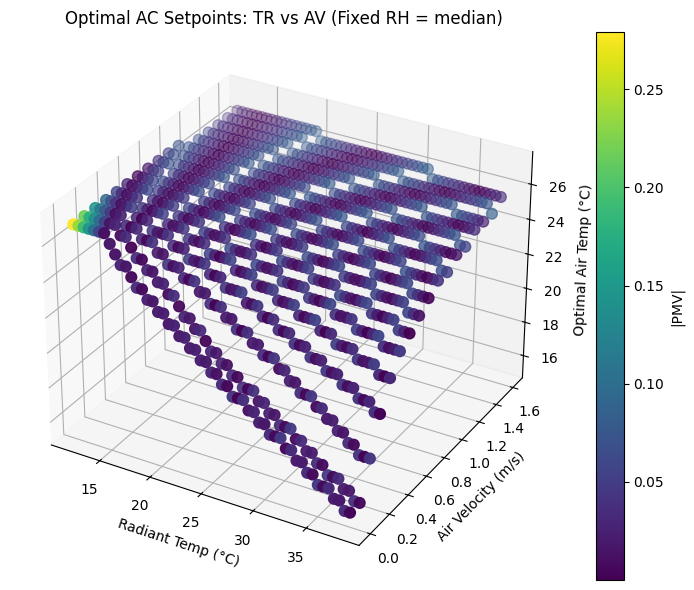

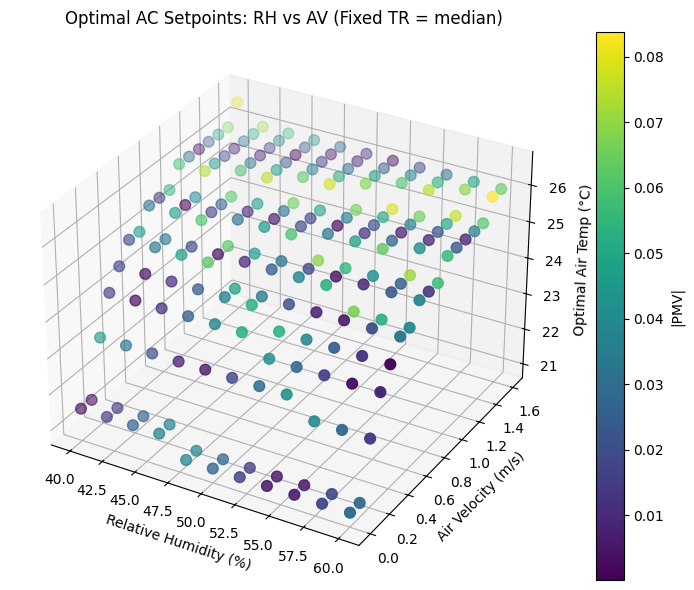

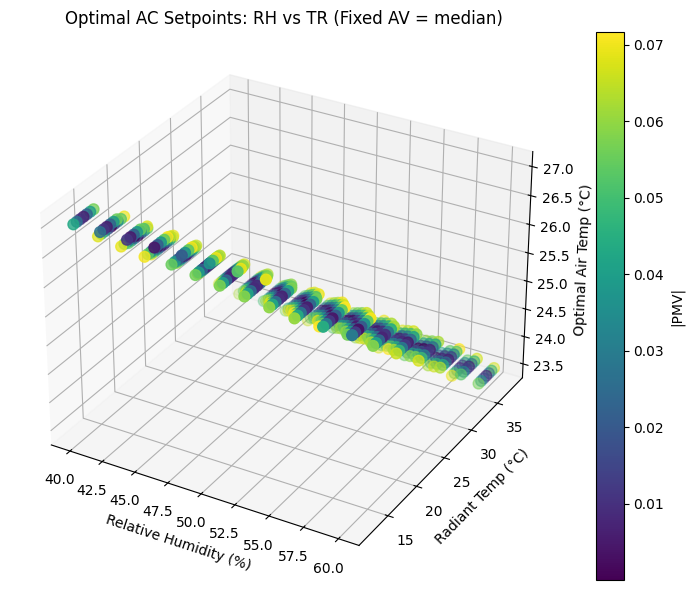

In [11]:
# ---------- Draw all 3D views ----------
plot3d("TR","AV",  title="Optimal AC Setpoints: TR vs AV (Fixed RH = median)")
plot3d("RH","AV",  title="Optimal AC Setpoints: RH vs AV (Fixed TR = median)")
plot3d("RH","TR",  title="Optimal AC Setpoints: RH vs TR (Fixed AV = median)")

## Multi-state Reward vs Temperature

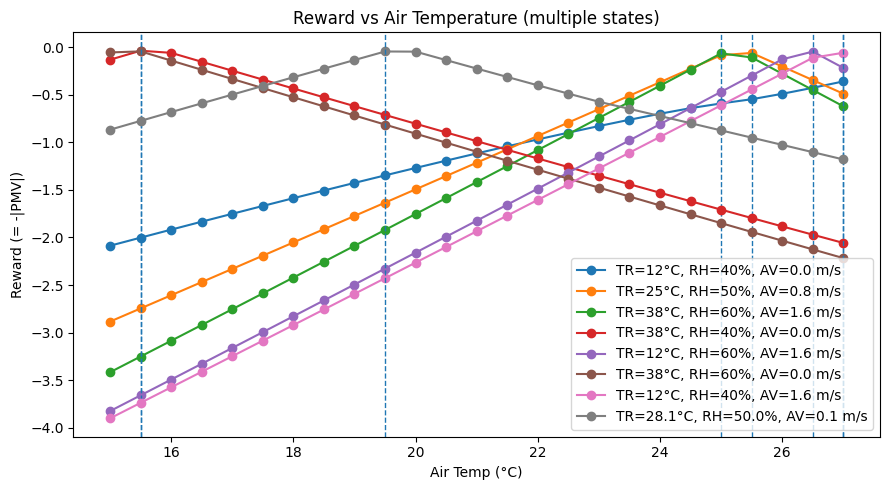

In [ ]:
states = [  # (TR, RH, AV)
    (12, 40, 0.0),    # low extreme
    (25, 50, 0.8),    # midpoint
    (38, 60, 1.6),    # high extreme
    (38, 40, 0.0),    # high TR, low RH, low AV
    (12, 60, 1.6),    # low TR, high RH, high AV
    (38, 60, 0.0),    # high TR, high RH, low AV
    (12, 40, 1.6),    # low TR, low RH, high AV
    (28.1, 50.0, 0.1) # real-world
]
plt.figure(figsize=(9,5))
for tr,rh,av in states:
    rew = [-abs(pmv_iso(ta,tr,av,rh) - 0.0) for ta in TA]
    plt.plot(TA, rew, marker="o", label=f"TR={tr}°C, RH={rh}%, AV={av} m/s")
    best = TA[int(np.argmax(rew))]; plt.axvline(best, linestyle="--", linewidth=1)
plt.title("Reward vs Air Temperature (multiple states)")
plt.xlabel("Air Temp (°C)"); plt.ylabel("Reward (= -|PMV|)"); plt.legend(); plt.tight_layout(); plt.show()

## Development of Supervised Behavioral Cloning

In [ ]:
# A tiny "DQN-style" learner using sklearn MLP to learn setpoint from (state, PMV_target).
try:
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    SK_OK = True
except Exception:
    SK_OK = False
    print("sklearn not installed → skipping DQN block.")

if SK_OK:
    rng = np.random.default_rng(42)

    # ---- 1) build physics-labeled dataset for multiple targets ----
    targets = np.array([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3], dtype=float)
    N_states = 600   # number of random states (kept small for speed)
    states_rand = np.column_stack([
        rng.choice(TR, N_states),
        rng.choice(RH, N_states),
        rng.choice(AV, N_states),
    ])
    X, y = [], []
    for pmv_t in targets:
        for tr,rh,av in states_rand:
            # find best action index on-the-fly (physics labels)
            pmv_vals = np.array([pmv_iso(ta, tr, av, rh) for ta in TA])
            idx = int(np.argmin(np.abs(pmv_vals - pmv_t)))
            X.append([tr, rh, av, 0.68, 1.2, pmv_t])  # features: state + target
            y.append(idx)                             # label: action index
    X = np.array(X, dtype=np.float32); y = np.array(y, dtype=np.int64)

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

    # ---- 2) train MLP classifier ----
    clf = MLPClassifier(hidden_layer_sizes=(64,64), activation="relu",
                        solver="adam", max_iter=200, random_state=42,
                        early_stopping=True, n_iter_no_change=15, verbose=False)
    clf.fit(Xtr, ytr)
    acc = clf.score(Xte, yte)
    print(f"DQN/MLP action accuracy vs VIA labels (test): {acc*100:.1f}%")

    # ---- 3) evaluate PMV tracking on test split (±0.3 metric) ----
    # apply predicted setpoint, compute |PMV - target|
    preds = clf.predict(Xte)
    errs = []
    for feat, idx in zip(Xte, preds):
        tr,rh,av,clo,met,pmv_t = feat
        ta = TA[int(idx)]
        pmv_val = pmv_iso(ta, tr, av, rh, met=met, clo=clo)
        errs.append(abs(pmv_val - pmv_t))
    errs = np.array(errs)
    print(f"DQN/MLP: % test states within ±0.3 PMV of target: {(errs<=0.3).mean()*100:.1f}% (mean |err|={errs.mean():.3f})")

    # ---- 4) demo predictions for a few states & targets (incl. unseen target) ----
    demo_states = [
        (25.0, 50.0, 0.6),  # typical office
        (30.0, 55.0, 0.2),  # warm radiant, low air speed
    ]
    demo_targets = [ -0.2, 0.0, 0.2, -0.15 ]  # include unseen target -0.15
    for tr,rh,av in demo_states:
        for t in demo_targets:
            idx = int(clf.predict([[tr,rh,av,0.68,1.2,t]])[0])
            ta = TA[idx]
            pmv_val = pmv_iso(ta, tr, av, rh)
            print(f"State(TR={tr},RH={rh},AV={av}), target={t:+.2f} → setpoint={ta:.1f}°C, PMV≈{pmv_val:+.3f}")


DQN/MLP action accuracy vs VIA labels (test): 57.4%
DQN/MLP: % test states within ±0.3 PMV of target: 91.6% (mean |err|=0.113)
State(TR=25.0,RH=50.0,AV=0.6), target=-0.20 → setpoint=24.0°C, PMV≈-0.239
State(TR=25.0,RH=50.0,AV=0.6), target=+0.00 → setpoint=25.0°C, PMV≈+0.024
State(TR=25.0,RH=50.0,AV=0.6), target=+0.20 → setpoint=26.0°C, PMV≈+0.288
State(TR=25.0,RH=50.0,AV=0.6), target=-0.15 → setpoint=24.5°C, PMV≈-0.107
State(TR=30.0,RH=55.0,AV=0.2), target=-0.20 → setpoint=21.5°C, PMV≈+0.152
State(TR=30.0,RH=55.0,AV=0.2), target=+0.00 → setpoint=22.5°C, PMV≈+0.340
State(TR=30.0,RH=55.0,AV=0.2), target=+0.20 → setpoint=22.5°C, PMV≈+0.340
State(TR=30.0,RH=55.0,AV=0.2), target=-0.15 → setpoint=21.5°C, PMV≈+0.152
